In [1]:
import os
import argparse
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.loggers import WandbLogger
from torch.utils.data import DataLoader
from multissl.plotting.false_color import visualize_batch_semi, visualize_predictions

In [2]:
from multissl.models import SegmentationModel, DomainAdaptiveSegmentationModel
from multissl.data import SegmentationDataset, SemiSupervisedSegmentationDataset, semi_supervised_collate_fn, get_transform

from multissl.data.seg_transforms import JointWeakAugmentation, JointStrongAugmentation

In [3]:
CONFIG = {
    # Dataset parameters
    "img_dir": "../dataset/vineseg/imgs",  # Update with your path
    "mask_dir": "../dataset/vineseg/masks",  # Update with your path
    "unlabeled_dir": ["../dataset/vineseg/imgs/train_qbaixo5","../dataset/vineseg/imgs/train_valdoeiro5",  ],  # Optional path or list of paths to unlabeled images
    "img_size": 224,
    "batch_size": 8,
    "num_workers": 8,
    
    # Model parameters
    "pretrained_checkpoint": "../checkpoints_512_r18_view4_v2/last.ckpt",
    "backbone_type": "resnet18",  # Options: resnet18, resnet50, vit-s, swin-tiny
    "num_classes": 2,
    "in_channels": 4,  # 4 channels for R+G+RE+NIR
    "hidden_dim": 256,
    
    # Training parameters
    "epochs": 100,
    "lr": 3e-4,
    "weight_decay": 1e-4,
    "consistency_weight": 1,
    "consistency_rampup": 20,  # Epochs for ramping up consistency weight
    "check_val_every_n_epoch": 5,  # Validate every N epochs
   
    # Domain adaptation parameters
    "unfreeze_backbone_after": None,  # Unfreeze backbone after this many epochs (None to keep frozen)
    
    # Misc
    "seed": 42,
    "class_names": ["Background", "Vines"],  # Update with your class names
    "checkpoint_dir": "domain_adaptive_checkpoints",
    "project_name": "DomainAdaptiveSegmentation",
    "class_names": ["Background","Vines"],  # Update with your class names
    "class_weights": [0.5,1.0]
}

In [4]:
# Create train/val/test datasets
pl.seed_everything(CONFIG["seed"])
#Built around 2 different tf pipelines due to Mask-image and non-labeled samples
joint_tf = JointStrongAugmentation()
unlabeled_tf = get_transform(img_size= 224)


train_dataset = SemiSupervisedSegmentationDataset(
        img_dir=os.path.join(CONFIG["img_dir"], "train5"),
        mask_dir=os.path.join(CONFIG["mask_dir"], "train5"),
        unlabeled_dir=CONFIG["unlabeled_dir"],
        img_size=CONFIG["img_size"],
        joint_transform=joint_tf,
        unlabeled_transform=unlabeled_tf
    )
    

val_dataset = SegmentationDataset(
    img_dir=os.path.join(CONFIG["img_dir"], "val_esac2"),
    mask_dir=os.path.join(CONFIG["mask_dir"], "val_esac2"),
    img_size=CONFIG["img_size"]
)

test_dataset_v = SegmentationDataset(
    img_dir=os.path.join(CONFIG["img_dir"], "test_valdoeiro"),
    mask_dir=os.path.join(CONFIG["mask_dir"], "test_valdoeiro"),
    img_size=CONFIG["img_size"]
)

test_dataset_q = SegmentationDataset(
    img_dir=os.path.join(CONFIG["img_dir"], "test_qbaixo"),
    mask_dir=os.path.join(CONFIG["mask_dir"], "test_qbaixo"),
    img_size=CONFIG["img_size"]
)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG["batch_size"],
    shuffle=True,
    num_workers=CONFIG["num_workers"],
    pin_memory=True,
    collate_fn = semi_supervised_collate_fn,
    persistent_workers = True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG["batch_size"],
    shuffle=False,
    num_workers=0,
    pin_memory=True,

)

test_loader_v = DataLoader(
    test_dataset_v,
    batch_size=CONFIG["batch_size"],
    shuffle=False,
    num_workers=0,
    pin_memory=True,

)
test_loader_q = DataLoader(
    test_dataset_q,
    batch_size=CONFIG["batch_size"],
    shuffle=False,
    num_workers=0,
    pin_memory=True,

)
# Print dataset sizes
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size valdoeiro: {len(test_dataset_v)}")
print(f"Test dataset size qbaixo: {len(test_dataset_q)}")

Seed set to 42


Dataset composition:
  - Labeled images: 5
  - Unlabeled images: 10
  - Total: 15
Train dataset size: 15
Validation dataset size: 97
Test dataset size valdoeiro: 158
Test dataset size qbaixo: 142


c:\users\judoj\documents\programming\multi_ssl\multissl\plotting\false_color.py:227: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


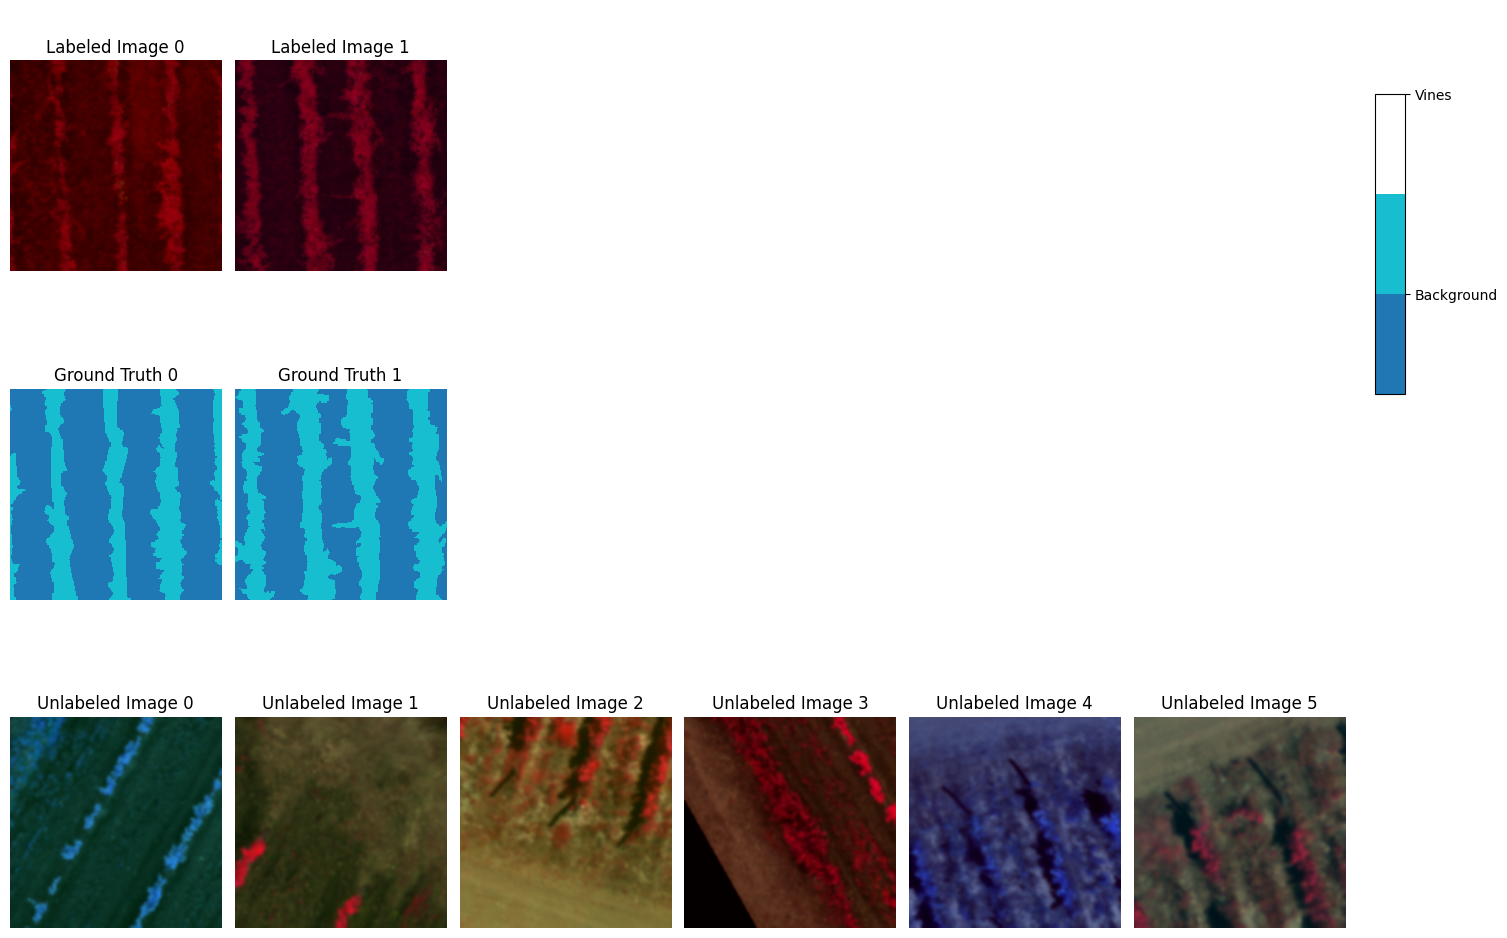

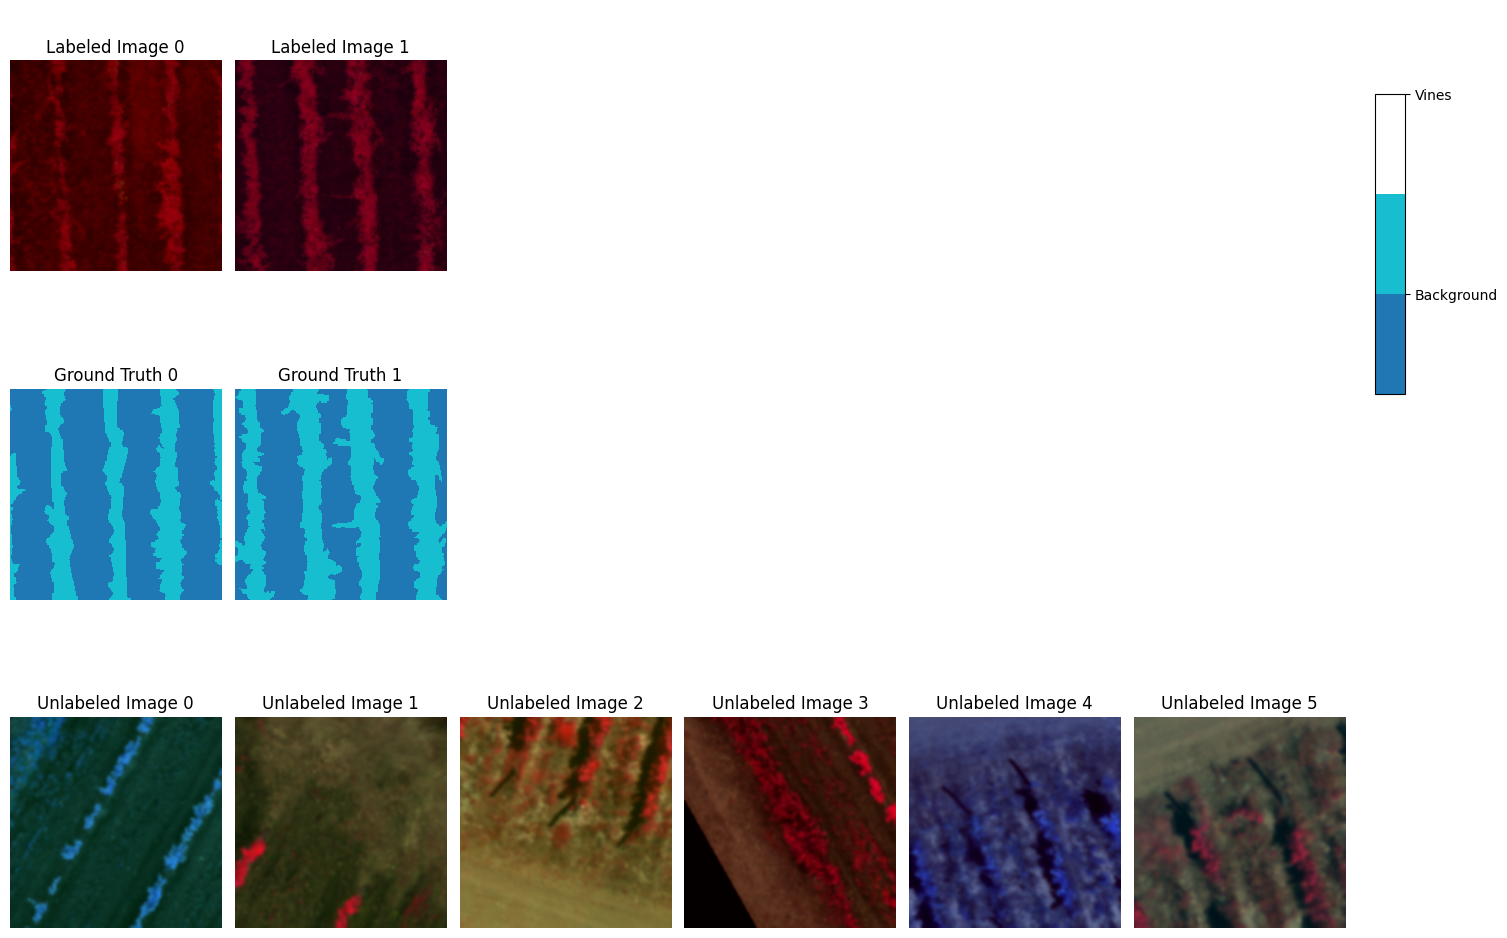

In [5]:
# Visualize a batch of training data
batch = next(iter(train_loader))
visualize_batch_semi(
    batch, 
    num_samples=8, 
    class_names=CONFIG["class_names"],
    num_classes=CONFIG["num_classes"] 
)

In [6]:
# For ResNet50 pretrained with FastSiam

model = DomainAdaptiveSegmentationModel(
        backbone_type=CONFIG["backbone_type"],
        pretrained_path=CONFIG["pretrained_checkpoint"],
        in_channels=CONFIG["in_channels"],
        num_classes=CONFIG["num_classes"],
        img_size=CONFIG["img_size"],
        #lr=CONFIG["lr"],
        weight_decay=CONFIG["weight_decay"],
        consistency_weight=CONFIG["consistency_weight"],
        consistency_rampup=CONFIG["consistency_rampup"],
        class_weights = CONFIG["class_weights"],
        confidence_threshold = CONFIG["confidence_threshold"]
    )

Detected feature dimensions: layer1=64, layer2=128, layer3=256, layer4=512


In [7]:
# Create callbacks
from pytorch_lightning.callbacks import RichProgressBar

checkpoint_callback = ModelCheckpoint(
    dirpath="segmentation_checkpoints",
    filename="r18_semi_da-{epoch:02d}-{val_loss:.4f}",
    save_top_k=3,
    monitor="val_loss",
    mode="min",
    save_last=True
)

lr_monitor = LearningRateMonitor(logging_interval="epoch")
# Create logger (you can use either WandbLogger or TensorBoardLogger)
# Comment out if you don't want to use wandb

wandb_logger = WandbLogger(project="ViT-Segmentation", log_model=False)

# Create trainer
trainer = pl.Trainer(
    max_epochs=CONFIG["epochs"],
    accelerator="cuda",  # Uses GPU if available
    devices=1,
    callbacks=[checkpoint_callback, lr_monitor, RichProgressBar()],
    logger=wandb_logger,  # Comment out if not using wandb
    log_every_n_steps = 1,
    check_val_every_n_epoch=5  # Only validate every 5 epochs
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [8]:
# Train the model
trainer.fit(model, train_loader, val_loader)
import wandb
wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jurriandoornbos (jurrain-phd) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Users\judoj\Documents\programming\multi_ssl\notebooks\segmentation_checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


┏━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name              ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ feature_extractor │ ResNetExtractor  │ 11.2 M │ train │
│ 1 │ adapter_module    │ AdapterModule    │  177 K │ train │
│ 2 │ segmentation_head │ SegmentationHead │  3.5 M │ train │
└───┴───────────────────┴──────────────────┴────────┴───────┘

Trainable params: 3.7 M                                                                                            
Non-trainable params: 11.2 M                                                                                       
Total params: 14.8 M                                                                                               
Total estimated model params size (MB): 59                                                                         
Modules in train mode: 129                                                                                         
Modules in eval mode: 0

Output()

C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425
: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

`Trainer.fit` stopped: `max_epochs=100` reached.


epoch,▁▁▁▁▁▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
lr-AdamW/pg1,███████████▄▄▄▃▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-AdamW/pg2,██████████▄▄▄▄▄▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-AdamW/pg3,██████████████▄▄▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_adapter_loss,█▆▆▅▅▄▂▃▂▂▂▁▂▂▁▃▃▂▂▁▂▃▂▃▂▂▂▂▂▁▃▂▂▂▂▃▁▂▂▂
train_adapter_loss_ema,██▇▇▇▆▅▅▄▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_confident_pixels_percent,▁▄▃▄▅▆▆▇▇▇██████████████████████████████
train_consistency_weight,▁▂▃▃▃▅▆█████████████████████████████████
train_supervised_loss,▅▆▅▄▄▄▂▃▃▃▅▄▃▂▃▄▃▂▂▂▁▂▂▁▃▁█▂▄▃▂▃▃▄▂▂▂▆▃▃
train_supervised_loss_ema,██▆▆▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▂▂▂▂
train_total_loss,▅▅▅▅▄▄▄▄▄▄▁▅▅▅▄▄▅▄▄▄▅▃█▄▄▆▄▄▄▃▄▄▄▄▄▄▅▄▄▄


Detected feature dimensions: layer1=64, layer2=128, layer3=256, layer4=512
Loaded best model from C:\Users\judoj\Documents\programming\multi_ssl\notebooks\segmentation_checkpoints\r18_semi_da-epoch=09-val_loss=0.6645.ckpt


C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\pytorch_lightning\core\module.py:441: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`



===== Test Set Evaluation =====
Loss: 0.4769
Accuracy: 0.7595
Total F1 Score (micro-avg): 0.7595
Mean IoU: 0.4225

Per-class metrics:
Background:
  Precision: 0.7727
  Recall: 0.9740
  F1 Score: 0.8558
  IoU: 0.7513
Vines:
  Precision: 0.6408
  Recall: 0.1014
  F1 Score: 0.1676
  IoU: 0.0937

Confusion Matrix:
tensor([[3514950,   70157],
        [1134191,  147774]], device='cuda:0')


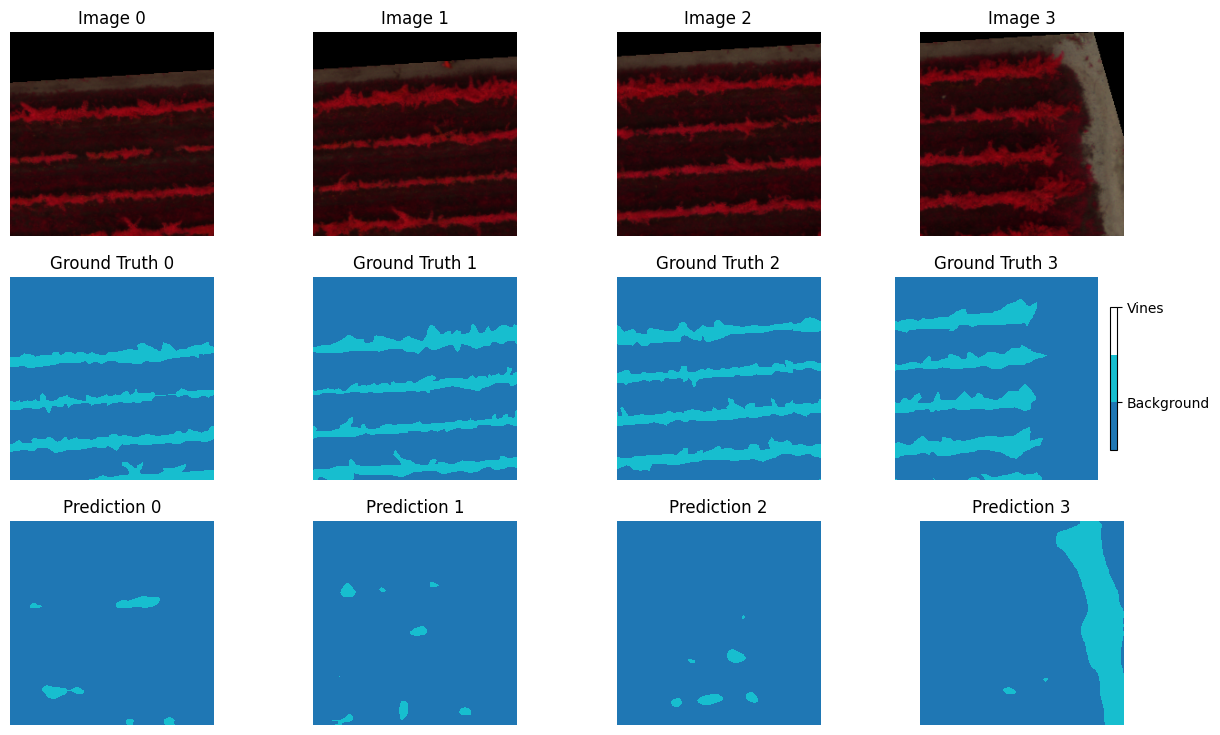

C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\pytorch_lightning\core\module.py:441: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`



===== Test Set Evaluation =====
Loss: 0.3382
Accuracy: 0.8437
Total F1 Score (micro-avg): 0.8437
Mean IoU: 0.5818

Per-class metrics:
Background:
  Precision: 0.9938
  Recall: 0.8354
  F1 Score: 0.9074
  IoU: 0.8310
Vines:
  Precision: 0.3406
  Recall: 0.9401
  F1 Score: 0.4957
  IoU: 0.3327

Confusion Matrix:
tensor([[6078704, 1207604],
        [  37828,  603672]], device='cuda:0')


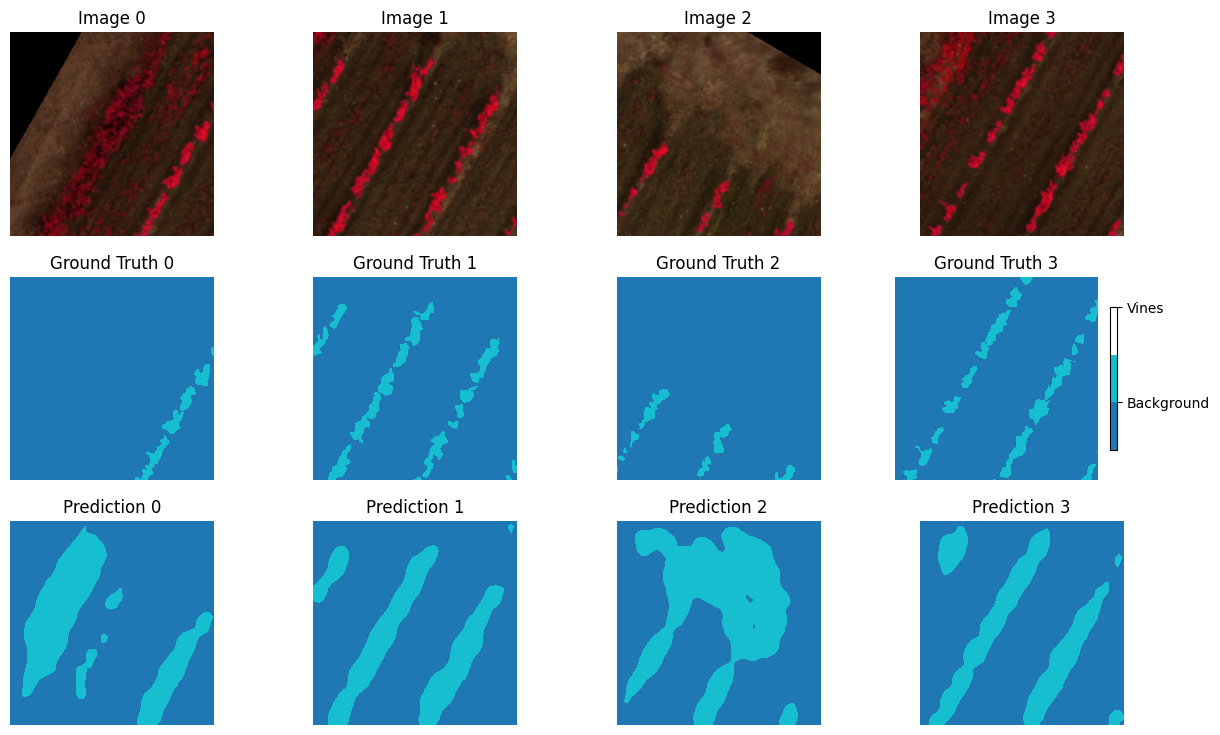

C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\pytorch_lightning\core\module.py:441: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`



===== Test Set Evaluation =====
Loss: 0.7906
Accuracy: 0.4899
Total F1 Score (micro-avg): 0.4899
Mean IoU: 0.2762

Per-class metrics:
Background:
  Precision: 0.7347
  Recall: 0.5575
  F1 Score: 0.6304
  IoU: 0.4691
Vines:
  Precision: 0.1154
  Recall: 0.2245
  F1 Score: 0.1507
  IoU: 0.0833

Confusion Matrix:
tensor([[3169940, 2540250],
        [1118351,  296451]], device='cuda:0')


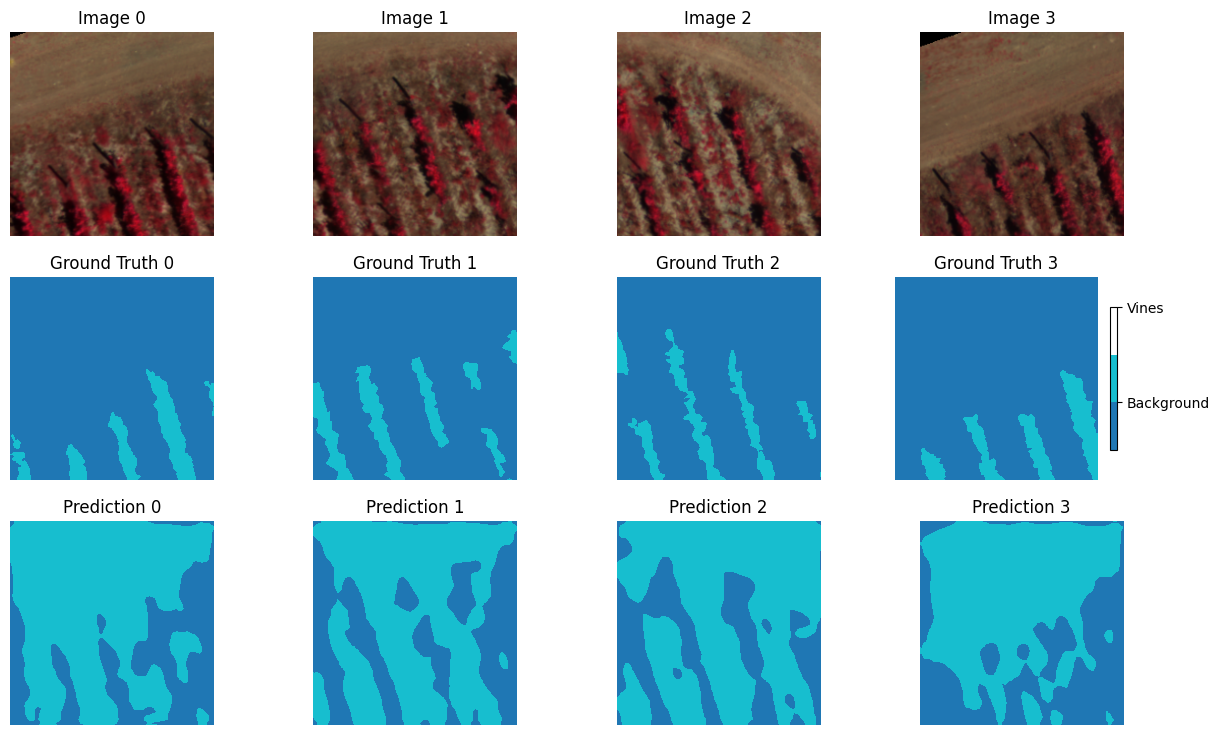

In [14]:
# Load the best model
device = "cuda"

best_model_path = checkpoint_callback.best_model_path
best_model = DomainAdaptiveSegmentationModel.load_from_checkpoint(best_model_path, 
                                                    backbone_type = "resnet18")

best_model.eval()

print(f"Loaded best model from {best_model_path}")

uber_test_results_e2 = best_model.test(val_loader)

visualize_predictions(
    model=best_model,
    dataloader=val_loader,
    device=device,
    num_samples=4,
    class_names=CONFIG["class_names"],
    num_classes=CONFIG["num_classes"]
)

uber_test_results_v = best_model.test(test_loader_v)


visualize_predictions(
    model=best_model,
    dataloader=test_loader_v,
    device=device,
    num_samples=4,
    class_names=CONFIG["class_names"],
    num_classes=CONFIG["num_classes"]
)

uber_test_results_q = best_model.test(test_loader_q)

visualize_predictions(
    model=best_model,
    dataloader=test_loader_q,
    device=device,
    num_samples=4,
    class_names=CONFIG["class_names"],
    num_classes=CONFIG["num_classes"]
)

In [73]:
# Save just the state dict for easier loading in production
model_state_dict_path = "segmentation_checkpoints/r50seg_all_best_state_dict.pth"
torch.save(best_model.state_dict(), model_state_dict_path)
print(f"Saved model state dict to {model_state_dict_path}")

Saved model state dict to segmentation_checkpoints/r50seg_all_best_state_dict.pth
